In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import cm
from io import StringIO
import pandas as pd

In [4]:
mangaid = ['1-156039', '1-22948', '1-258599', '1-269632', '1-284293', '1-43214', '1-574402', '1-72322']
nsa_z = [0.114699, 0.119399, 0.125582, 0.131457, 0.129080, 0.117997, 0.131997, 0.126168]

In [5]:
drpall_list = fits.open("/Users/natachaupra/Desktop/Snr_Prj/Snr-Prj/platelist-v2_4_3.fits")

In [6]:
objlist = drpall_list[2].data

In [7]:
plateifu = {}
# lst = []
for i in range(len(objlist)):
    if objlist[i][3] in mangaid:
        if objlist[i][3] in plateifu:
            plateifu[objlist[i][3]].append(objlist[i][2])
        else:
            plateifu[objlist[i][3]] = [objlist[i][2]]

In [8]:
plateifu

{'1-156039': ['8439-3704'],
 '1-72322': ['8143-6101'],
 '1-574402': ['8137-3702'],
 '1-269632': ['9049-1901'],
 '1-284293': ['8318-6102'],
 '1-22948': ['7992-9102'],
 '1-258599': ['8464-6101'],
 '1-43214': ['8135-1902']}

In [9]:
def filename(plateifu_id):
    objname = 'manga-'+plateifu_id+'-LOGCUBE.fits.gz'
    name = '/Users/natachaupra/Downloads/'+ objname
    filedata = fits.open(name)
    return filedata

In [10]:
def dataReader(plateifu_id):
    data = filename(plateifu_id)
    flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))
    mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    wave = data['WAVE'].data
    flux_header  = data['FLUX'].header
    ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))
    return (flux, mask, wave, flux_header, ivar)

In [11]:
def fluxReader(plateifu_id):
    data = filename(plateifu_id)
    flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))
    wave = data['WAVE'].data
    flux_header  = data['FLUX'].header
    mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    return (flux, wave, flux_header, mask)

In [12]:
def sumflux_calc(flux, mask):
    do_not_use = (mask & 2**10) != 0 
    n = len(flux)
    sumflux = np.zeros(4563)
    
    for i in range(n):
        for j in range(n):
            flux[i,j] = flux[i,j] * ~do_not_use[i,j]
            sumflux = np.add(sumflux, flux[i,j])
    return sumflux

In [13]:
def FluxGenerator(plateifu_id, mangaid, z, start, end, start2, end2):
    
    flux, wave, flux_header, mask = fluxReader(plateifu_id)
    
    wave_emit = wave/(1+z)

    sumflux = sumflux_calc(flux, mask)
    
    x_center = int(flux_header['CRPIX1']) - 1
    y_center = int(flux_header['CRPIX2']) - 1
    
    plt.figure(figsize = (12,5))
    plt.grid()
    plt.xlabel('Observed Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.xlim(4900, 5700)
    plt.ylim(0,8)
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave, flux[x_center, y_center], color = 'turquoise', linewidth = 2, label = 'center') 
    plt.legend()
#     plt.savefig('Images/{}CenFlux.png'.format(mangaid))
    plt.show()
    
    plt.figure(figsize = (12,5))
    plt.grid()
    plt.xlabel('Observed Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.ylim(0,700)
    plt.xlim(4900, 5700)
#     plt.axvline(5007, color = 'mediumseagreen', linewidth = 2, label = '5007')
#     plt.axvline(4959, color = 'deepskyblue', linewidth = 2, label = '4959')
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave, sumflux, color = 'darkmagenta')
    plt.axvline(start, label = str(start), color = 'teal', linewidth = 2)
    plt.axvline(end, label = str(end), color = 'teal', linewidth = 2)
    plt.legend()
#     plt.savefig('Images/{}ObsFlux.png'.format(mangaid))
    plt.show()
    
    plt.figure(figsize = (12,5))
    plt.grid()
    plt.xlabel('Rest Frame ' + r'[$\AA$]')
    plt.ylabel('(Observed) Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.ylim(0,700)
    plt.xlim(4900, 5700)
    plt.axvline(5007, color = 'mediumseagreen', linewidth = 2, label = '5007')
    plt.axvline(4959, color = 'deepskyblue', linewidth = 2, label = '4959')
    plt.axvline(start2, label = str(start2), color = 'blue', linewidth = 2)
    plt.axvline(end2, label = str(end2), color = 'blue', linewidth = 2)
    plt.legend()
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave_emit, sumflux, color = 'tomato')
#     plt.savefig('Images/{}EmitFlux.png'.format(mangaid), bbox_inches = 'tight')
    plt.show()

In [14]:
def imageGenerator(plateifu_id, mangaID, redshift, start, end):
    flux, mask, wave, flux_header, ivar = dataReader(plateifu_id)

    
#     start = 5500
#     end = 5700
    
#     x_center = int(flux_header['CRPIX1']) - 1
#     y_center = int(flux_header['CRPIX2']) - 1

    do_not_use = (mask & 2**10) != 0
    flux_m = np.ma.array(flux, mask=do_not_use)

    ind_wave = np.where((wave / (1 + redshift) > start) & (wave / (1 + redshift) < end))[0]
    halpha = flux_m[:, :, ind_wave].sum(axis=2)
    im = halpha.T

    # Convert from array indices to arcsec relative to IFU center
    dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
    dy = flux_header['CD2_2'] * 3600.  # deg to arcsec

    dimension = [0, len(flux[0]), 0, len(flux)]
    
    plt.figure(figsize = (7,7))
#     plt.imshow(im, extent=dimension, cmap=cm.YlGnBu_r, vmin=0.1, vmax=100, origin='lower', interpolation='none')
    plt.imshow(im, extent=dimension, cmap=cm.YlGnBu_r, origin='lower', interpolation='none')
    plt.xlabel('pixels')
    plt.ylabel('pixels')
    plt.title('MaNGA ID = ' + mangaID + ' ($\lambda$ : ' + str(start) + ' - ' + str(end)  + ')')
    plt.colorbar(label = '1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$')
    plt.plot()
#     plt.savefig('Images/{}2DObsSelect.png'.format(mangaID), bbox_inches = 'tight')
#     plt.savefig('Images/{}2DObs.png'.format(mangaID), bbox_inches = 'tight')
#     plt.savefig('Images/{}2DEmitSelect.png'.format(mangaID), bbox_inches = 'tight')
#     plt.savefig('Images/demo_2d_13')

In [15]:
def WholeFlux(plateifu_id, mangaid, z):
    flux, wave, flux_header, mask = fluxReader(plateifu_id)
    
    wave_emit = wave/(1+z)

    sumflux = sumflux_calc(flux, mask)
    
    x_center = int(flux_header['CRPIX1']) - 1
    y_center = int(flux_header['CRPIX2']) - 1
    
    plt.figure(figsize = (20,4))
    plt.grid()
    plt.xlabel('Observed Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.axvline(5007, color = 'mediumseagreen', linewidth = 2, label = '5007')
    plt.axvline(4959, color = 'deepskyblue', linewidth = 2, label = '4959')
#     plt.xlim(4900, 5700)
    plt.ylim(0,8)
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave, flux[x_center, y_center], color = 'royalblue', linewidth = 2, label = 'center') 
    plt.legend()
#     plt.savefig('Images/{}CenFluxWhole.png'.format(mangaid))
    plt.show()
    
    plt.figure(figsize = (20,4))
    plt.grid()
    plt.xlabel('Observed Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.ylim(0,1000)
#     plt.xlim(5500, 5700)
    plt.axvline(5007, color = 'mediumseagreen', linewidth = 2, label = '5007')
    plt.axvline(4959, color = 'deepskyblue', linewidth = 2, label = '4959')
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave, sumflux, color = 'black')
#     plt.axvline(start, label = str(start), color = 'teal', linewidth = 2)
#     plt.axvline(end, label = str(end), color = 'teal', linewidth = 2)
    plt.legend()
#     plt.savefig('Images/{}ObsFluxWhole.png'.format(mangaid), bbox_inches = 'tight')
    plt.show()
    
    plt.figure(figsize = (20,4))
    plt.grid()
    plt.xlabel('Rest Frame ' + r'[$\AA$]')
    plt.ylabel('(Observed) Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.ylim(0,1000)
#     plt.xlim(4850, 5100)
    plt.axvline(5007, color = 'mediumseagreen', linewidth = 2, label = '5007')
    plt.axvline(4959, color = 'deepskyblue', linewidth = 2, label = '4959')
#     plt.axvline(start2, label = str(start2), color = 'magenta', linewidth = 2)
#     plt.axvline(end2, label = str(end2), color = 'magenta', linewidth = 2)
    plt.legend()
    plt.title('MaNGA ID = ' + mangaid)
    plt.plot(wave_emit, sumflux, color = 'darkgrey')
#     plt.savefig('Images/{}EmitFluxWhole.png'.format(mangaid), bbox_inches = 'tight')
    plt.show()
    
    

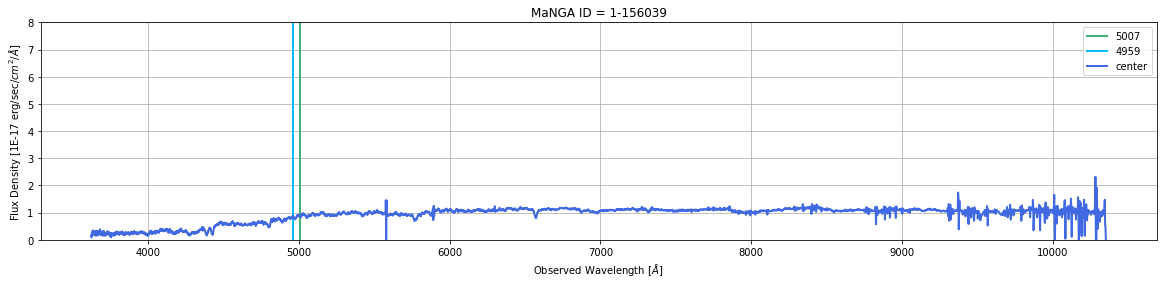

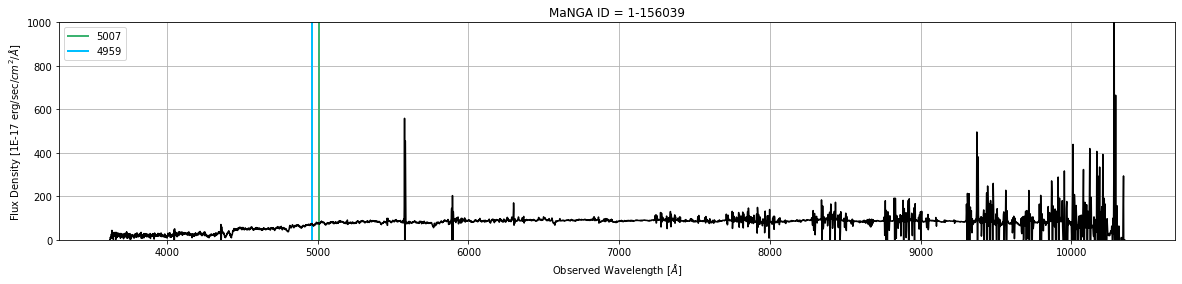

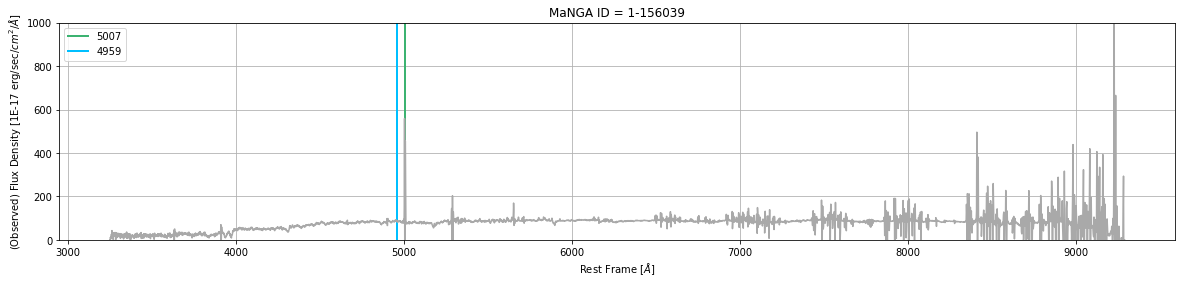

In [16]:
num = 0
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5570, 5590)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4995, 5012)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

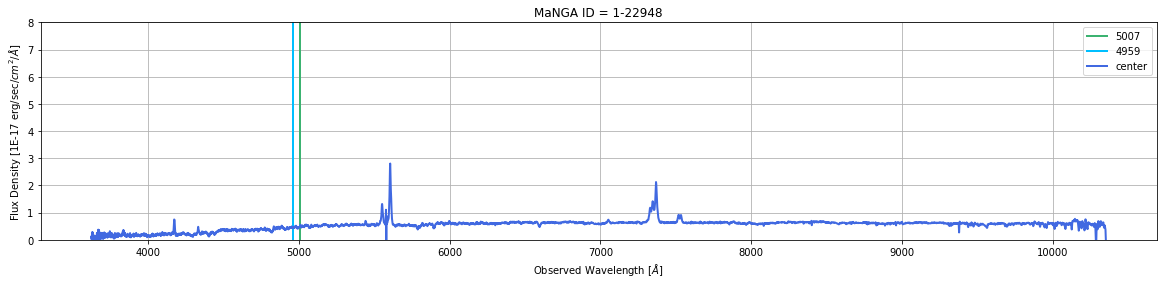

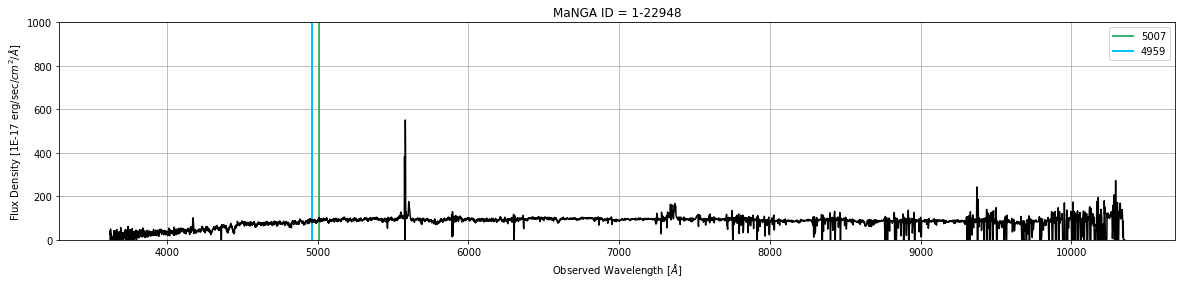

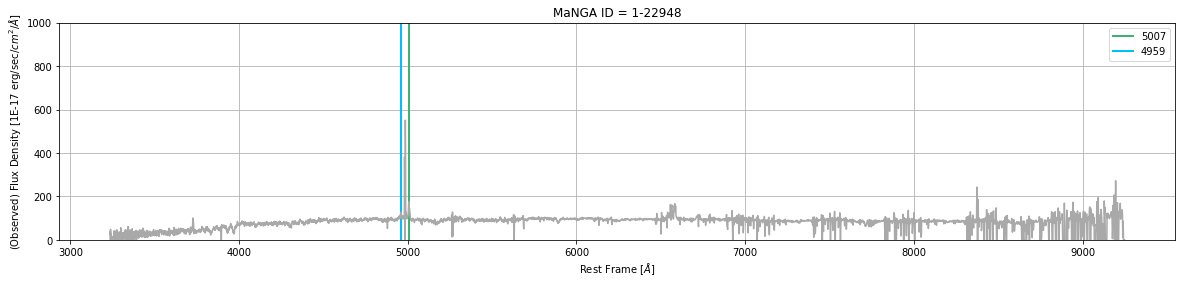

In [17]:
num = 1
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5590, 5620)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4495, 5020)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

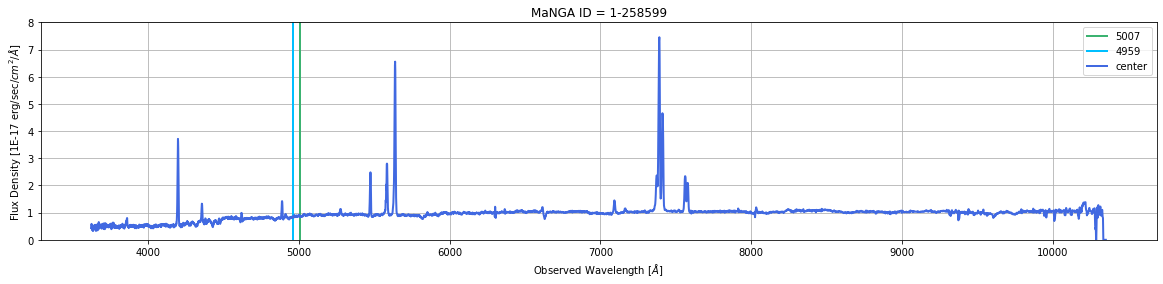

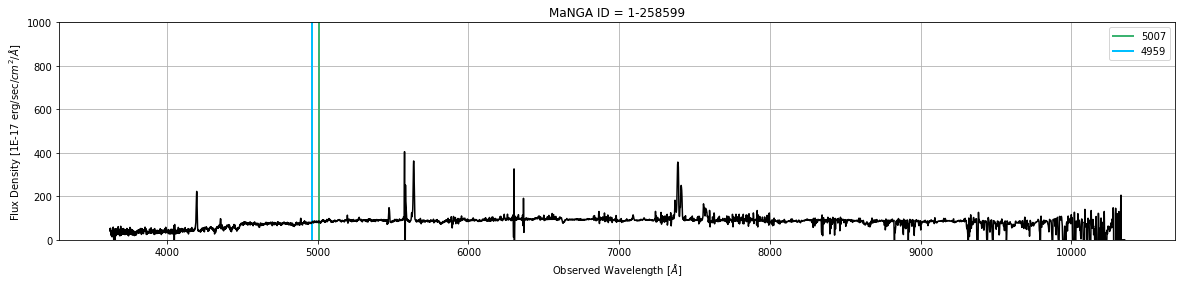

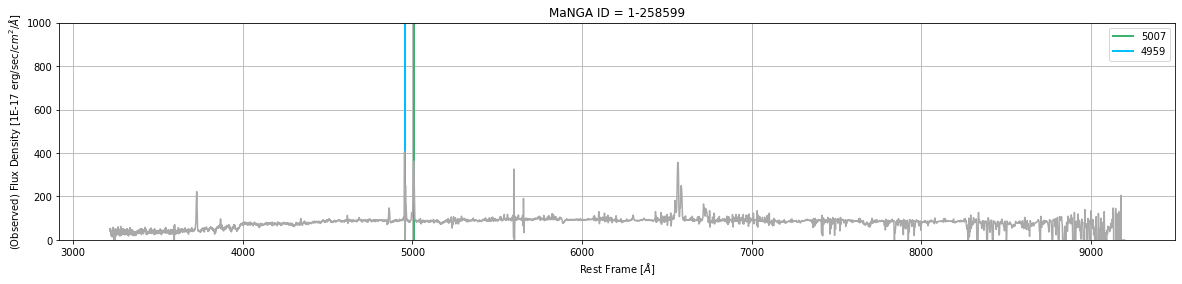

In [18]:
num = 2
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5610, 5655)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4985, 5025)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

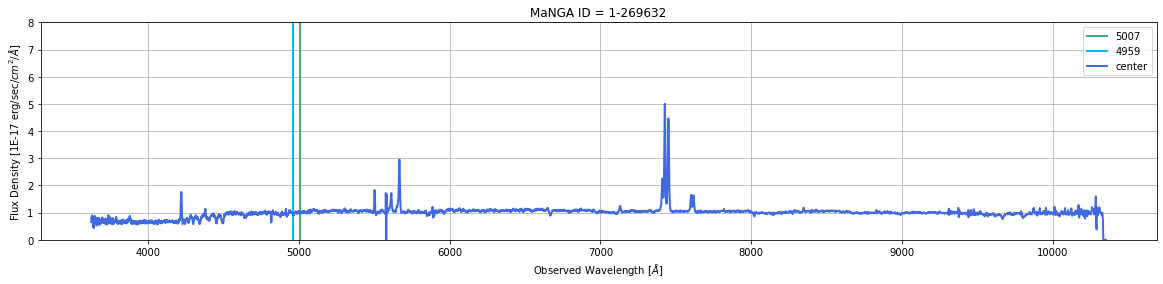

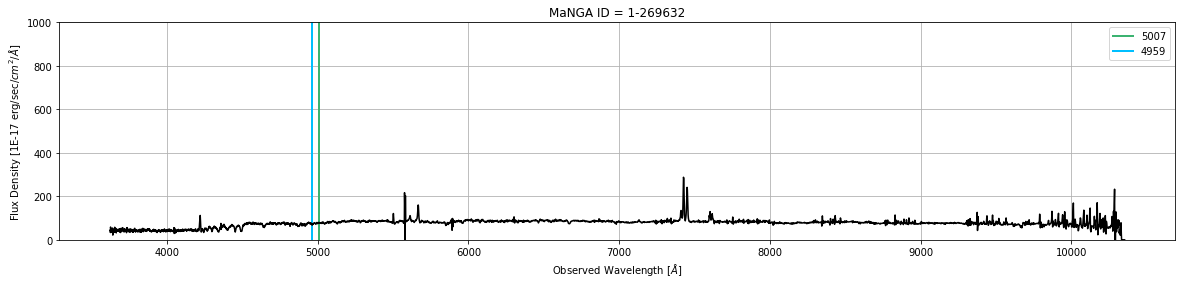

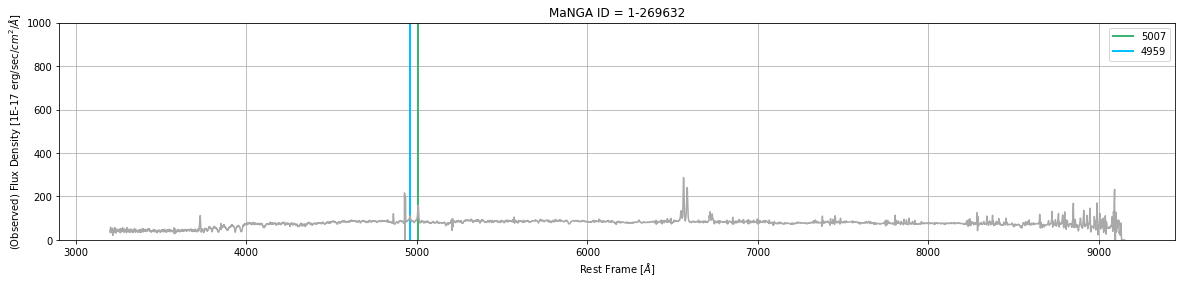

In [19]:
num = 3
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5650, 5680)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4985, 5025)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

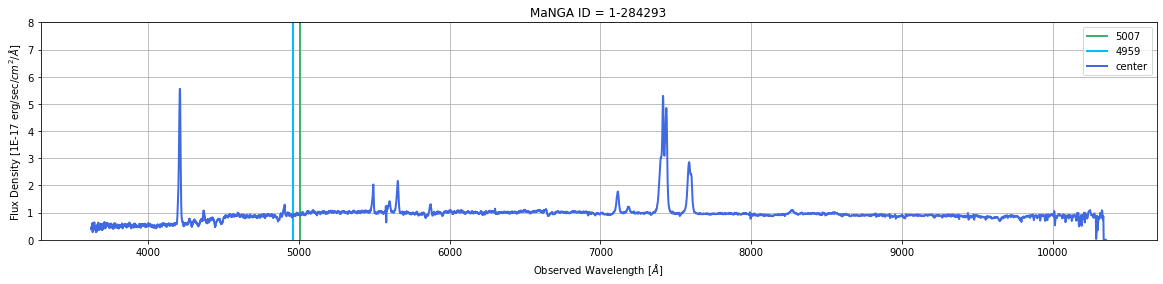

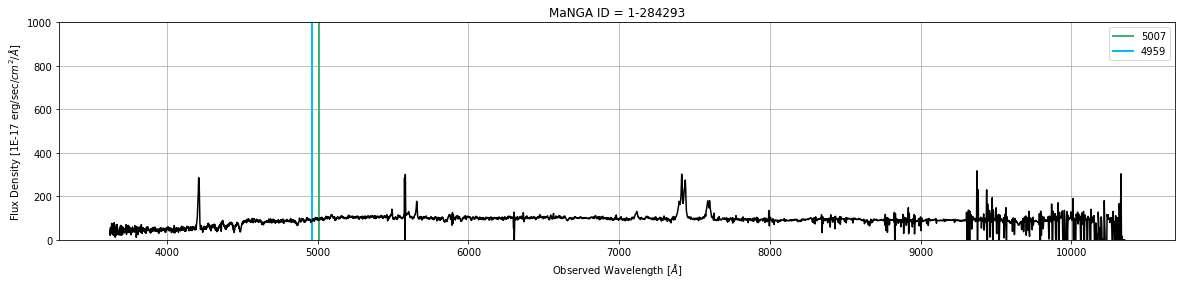

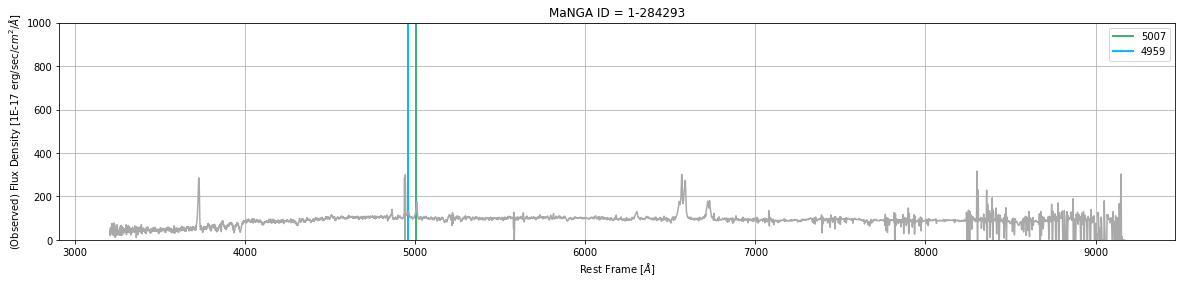

In [20]:
num = 4
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5635, 5675)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4985, 5025)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

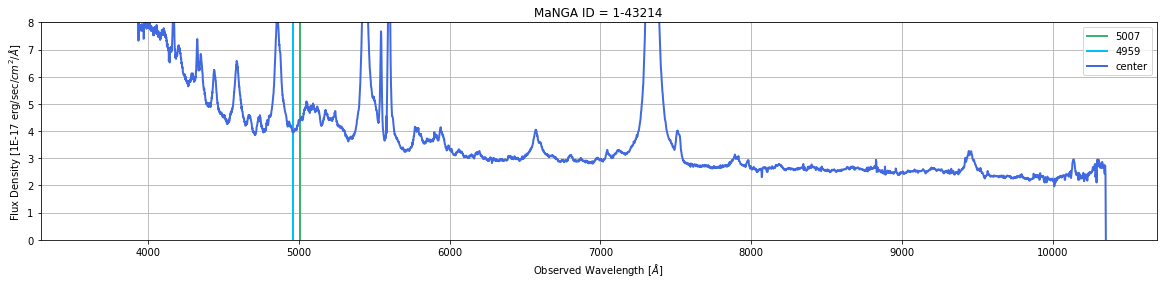

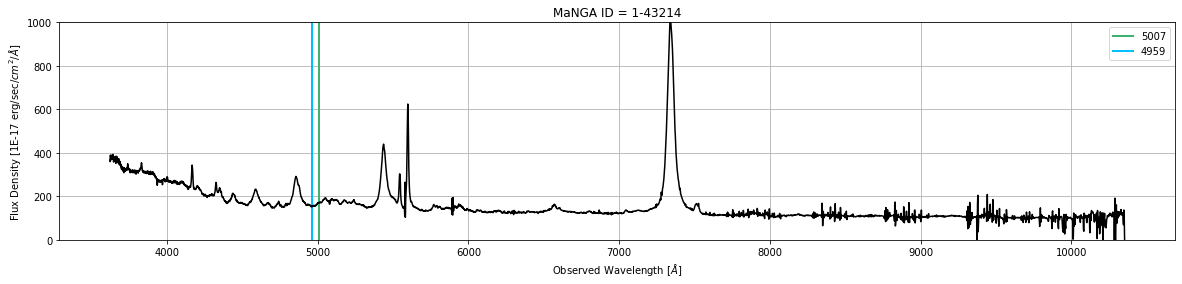

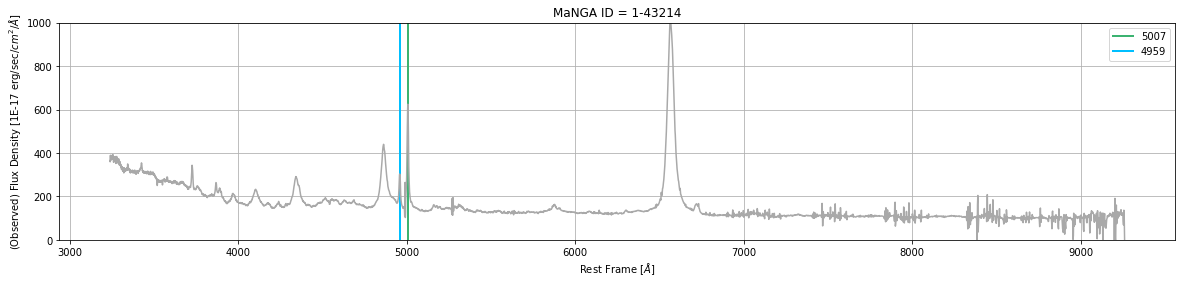

In [21]:
num = 5
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5582, 5620)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5582, 5620)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

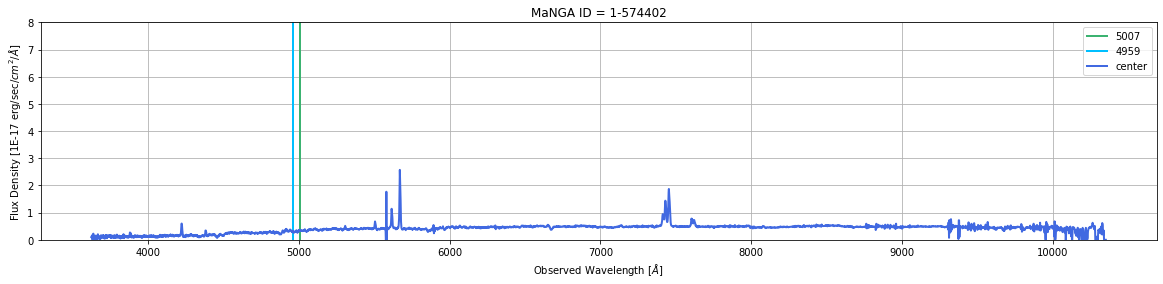

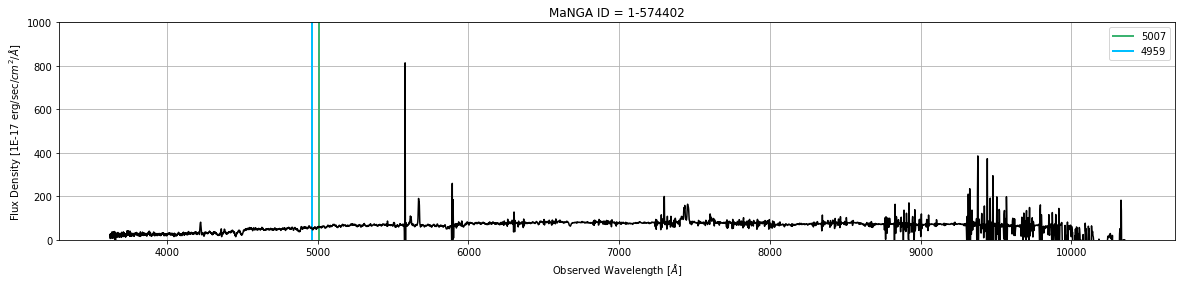

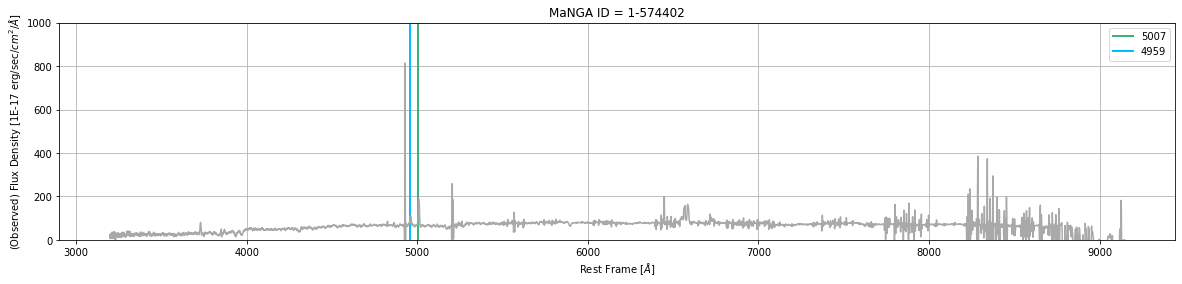

In [22]:
num = 6
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5655, 5685)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4995, 5020)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])

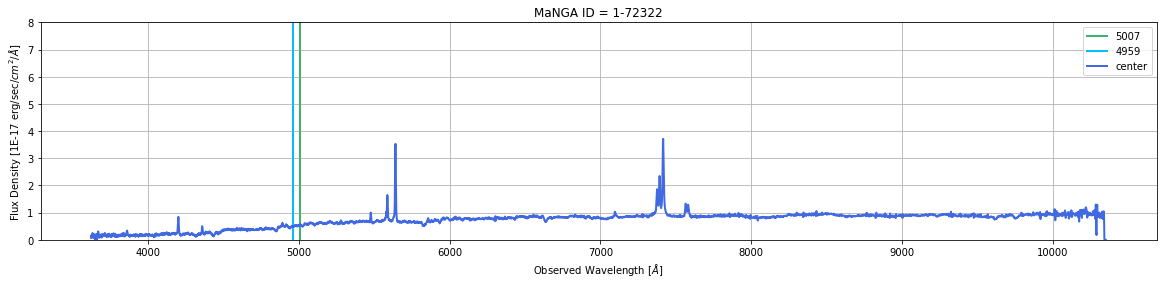

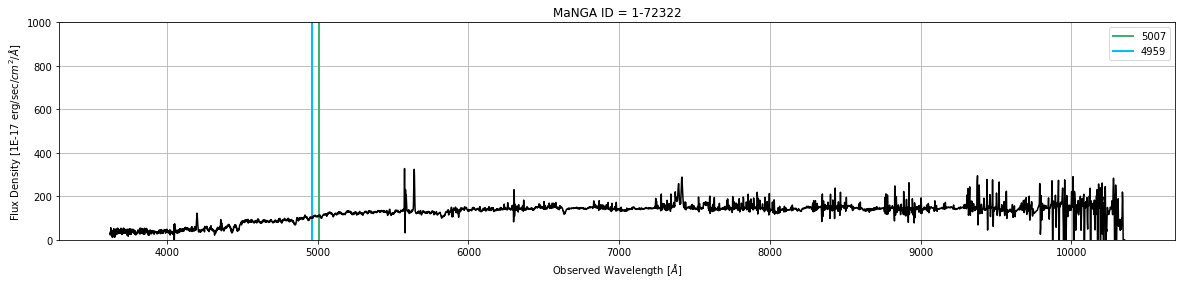

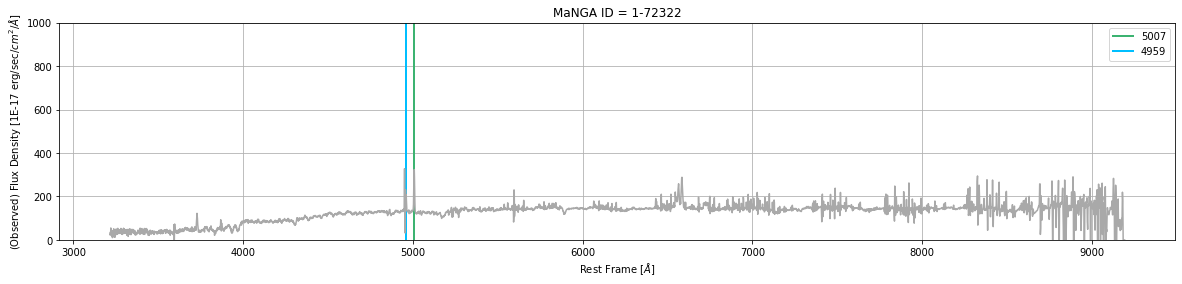

In [23]:
num = 7
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 5625, 5655)
# imageGenerator(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num], 4995, 5020)
WholeFlux(plateifu[mangaid[num]][0], mangaid[num], nsa_z[num])